In [1]:
!pip install xgboost
!pip install shap
!pip install explainerdashboard
!pip install --upgrade fairlearn==0.7.0 raiwidgets

# Dateset:
- https://www.kaggle.com/saniyajaswani/credit-card-data

In [2]:
# import all modules
from pathlib import Path
from google.colab import drive

import pandas as pd #we use this to load, read and transform the dataset
import numpy as np #we use this for statistical analysis
import matplotlib.pyplot as plt #we use this to visualize the dataset
import seaborn as sns #we use this to make countplots

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder # scale numeric features
from sklearn.model_selection import train_test_split # train test split data

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import metrics

import shap

from explainerdashboard import RegressionExplainer, ExplainerDashboard

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from fairlearn.metrics import selection_rate, MetricFrame
from fairlearn.reductions import GridSearch, EqualizedOdds, FalsePositiveRateParity, BoundedGroupLoss, ZeroOneLoss

#from raiwidgets import FairnessDashboard


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`


In [3]:
# let´s mount the some folders for e.g. training data and models etc.
drive.mount('/content/gdrive')

# create data and model folders
MODELPATH = "gdrive/MyDrive/CLV_RAI/models"
DATAPATH = "gdrive/MyDrive/CLV_RAI/data"
IMAGEPATH = "gdrive/MyDrive/CLV_RAI/images"
DASHBOARDPATH = "gdrive/MyDrive/CLV_RAI/dashboard"

Path(MODELPATH).mkdir(parents=True, exist_ok=True)
Path(DATAPATH).mkdir(parents=True, exist_ok=True)
Path(IMAGEPATH).mkdir(parents=True, exist_ok=True)
Path(DASHBOARDPATH).mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
df = pd.read_csv(DATAPATH / Path('cltv_bank.csv'))
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [5]:
# is the customer id unique?
print('df got {} datasets'.format(df.shape[0]))
print('df got {} unique customers'.format(df.Customer.unique().shape[0]))

df got 9134 datasets
df got 9134 unique customers


In [6]:
# check missing values
df.isnull().sum()

Customer                         0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
dtype: int64

In [7]:
# what type of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

# Define Feature Types and Target

In [8]:
target = ['Customer Lifetime Value']

numeric_features = ['Income', 
                    'Monthly Premium Auto', 
                    'Months Since Last Claim', 
                    'Months Since Policy Inception', 
                    'Number of Open Complaints', 
                    'Number of Policies', 
                    'Total Claim Amount']

cat_features = ['State', 'Response', 'Coverage', 'Education', 'EmploymentStatus', 
                'Policy Type', 'Policy', 'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size',
                'Gender', 'Marital Status', 'Location Code']

sensitive_features = ['Gender'] # we try to avoid any unfair model behavior along gender, marital status or location code

In [9]:
# reorder columns
df = df[numeric_features + cat_features + target]


In [10]:
df.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code,Customer Lifetime Value
0,56274,69,32,5,0,1,384.811147,Washington,No,Basic,...,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,2763.519279
1,0,94,13,42,0,8,1131.464935,Arizona,No,Extended,...,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize,F,Single,Suburban,6979.535903
2,48767,108,18,38,0,2,566.472247,Nevada,No,Premium,...,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,12887.431650
3,0,106,18,65,0,7,529.881344,California,No,Basic,...,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize,M,Married,Suburban,7645.861827
4,43836,73,12,44,0,1,138.130879,Washington,No,Basic,...,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize,M,Single,Rural,2813.692575


# Let´s artificially introduce a gender bias

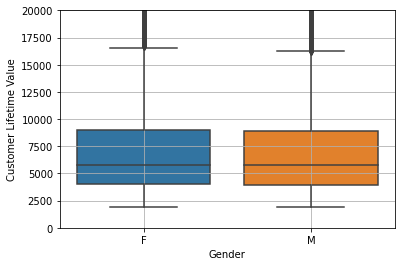

In [11]:
sns.boxplot(x='Gender', y='Customer Lifetime Value', data=df)
plt.grid('on')
plt.ylim(0,20000)
plt.show()

In [12]:
df.groupby(by='Gender').mean()['Customer Lifetime Value']

Gender
F    8096.602370
M    7909.551488
Name: Customer Lifetime Value, dtype: float64

In [13]:
df.groupby(by='Gender').std()['Customer Lifetime Value']

Gender
F    6956.059575
M    6780.743219
Name: Customer Lifetime Value, dtype: float64

In [14]:
# Let´s introduce the gender bias in terms that the customer life time value is clear less predictable for men than for women;
# in order to realize that, we add artificial normal noise to the men´s CLVs keeping the mean value unaffected

In [15]:
df.shape

(9134, 22)

In [16]:
df.loc[df['Gender']=='M'].shape[0]

4476

In [17]:
# let´s generate the noise
mean = 0
std = 2000
len = df.loc[df['Gender']=='M'].shape[0]
noise_array = np.random.normal(mean, std, len)
noise_array

array([ 2878.41121049,   459.58717856,  2114.82036355, ...,
       -1530.30678981, -2465.4478145 ,  1728.979371  ])

In [18]:
# let´s add the noise
df.loc[df['Gender']=='M', 'Customer Lifetime Value'] = df.loc[df['Gender']=='M', 'Customer Lifetime Value'] + noise_array

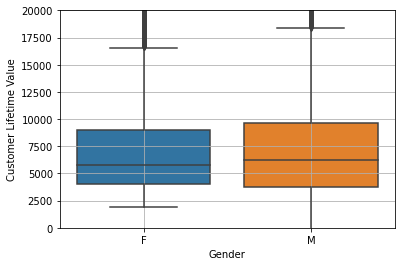

In [19]:
sns.boxplot(x='Gender', y='Customer Lifetime Value', data=df)
plt.grid('on')
plt.ylim(0,20000)
plt.show()

In [20]:
df.groupby(by='Gender').mean()['Customer Lifetime Value']

Gender
F    8096.602370
M    7859.303316
Name: Customer Lifetime Value, dtype: float64

In [21]:
df.groupby(by='Gender').std()['Customer Lifetime Value']

Gender
F    6956.059575
M    7059.992419
Name: Customer Lifetime Value, dtype: float64

# Lets do EDA on numeric features first

In [22]:
df[numeric_features].head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
0,56274,69,32,5,0,1,384.811147
1,0,94,13,42,0,8,1131.464935
2,48767,108,18,38,0,2,566.472247
3,0,106,18,65,0,7,529.881344
4,43836,73,12,44,0,1,138.130879


In [23]:
# descriptive statistics for numeric data
df.describe()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Customer Lifetime Value
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794,7980.317000
std,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092,7007.803517
min,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,-4466.114788
25%,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244,3849.914405
50%,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434,5992.783624
75%,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839,9327.723808
max,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678,83399.682160


In [24]:
# what about pearson correlation?
df[target + numeric_features].corr()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
Customer Lifetime Value,1.000000,0.022656,0.390436,0.010517,0.010368,-0.039152,0.022147,0.222691
Income,0.022656,1.000000,-0.016665,-0.026715,-0.000875,0.006408,-0.008656,-0.355254
Monthly Premium Auto,0.390436,-0.016665,1.000000,0.005026,0.020257,-0.013122,-0.011233,0.632017
Months Since Last Claim,0.010517,-0.026715,0.005026,1.000000,-0.042959,0.005354,0.009136,0.007563
Months Since Policy Inception,0.010368,-0.000875,0.020257,-0.042959,1.000000,-0.001158,-0.013333,0.003335
Number of Open Complaints,-0.039152,0.006408,-0.013122,0.005354,-0.001158,1.000000,0.001498,-0.014241
Number of Policies,0.022147,-0.008656,-0.011233,0.009136,-0.013333,0.001498,1.000000,-0.002354
Total Claim Amount,0.222691,-0.355254,0.632017,0.007563,0.003335,-0.014241,-0.002354,1.000000


Apparently we see some noticeable correlation between CLV, monthly premium auto and total claim amount

In [ ]:
# lets have a look
sns.pairplot(df[target + numeric_features].sample(50))
plt.show()

so far, the chances are pretty low that we get some good CLV prediction by using the weakly correlated numeric data only (which I was hoping :-) )
so let´s go about the categorical data and hope for something good to happen ;-)

# Lets do EDA on categorical features

In [ ]:
df[target + cat_features].head()

In [ ]:
# plot a bar plot for each categorical feature count
for col in cat_features:
    counts = df[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()

With respect to the sensitive feature employment status, we dont want e.g. disabled people to be scored unfairly. With respect to the sensitive feature gender, we dont want male, female to be scored differently etc..

In [ ]:
# plot a boxplot for the label by each categorical feature
for feat in cat_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    df.boxplot(column='Customer Lifetime Value', by = feat, ax = ax)
    ax.set_ylabel("Customer Lifetime Value")
    plt.show()

With respect to the features "coverage" and "vehicle class", we see some apparent effect on CLV.

# Train-Test Split

In [ ]:
df.head()

In [ ]:
# Separate features and labels
X, y = df[numeric_features + cat_features], df[target].values
print('Features:',X[:3], '\nLabels:', y[:3], sep='\n')

In [ ]:
# Split data into training set and test set
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, y, df, test_size=0.40, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

## Scale Numeric Data

In [ ]:
# scale numeric features
scaler = RobustScaler(quantile_range=(10,90))
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_train.head()

# Label-Encoding Categorical Data


In [ ]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [ ]:
# init encoder
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)
# fit encoder
enc.fit(X_train[cat_features])

In [ ]:
# transform data
X_train[cat_features] = enc.transform(X_train[cat_features])
X_train.head()

# Transform Hold-Out Dataset

In [ ]:
# scale numeric data
X_test[numeric_features] = scaler.transform(X_test[numeric_features])
# transform data
X_test[cat_features] = enc.transform(X_test[cat_features])
X_test.head()

# Model Selection: LightGBM vs Boosted Tree

In [ ]:
lgb_model = LGBMRegressor().fit(X_train, y_train.reshape(-1))
print (lgb_model)

In [ ]:
# Evaluate Model
predictions = lgb_model.predict(X_test).reshape(-1)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Customer Lifetime Value Predictions')

# overlay the regression line
z = np.polyfit(y_test.reshape(-1), predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.grid('on')
plt.show()

In [ ]:
# Train XGB model
xgb_model = XGBRegressor().fit(X_train, y_train)
print (xgb_model)

In [ ]:
# Evaluate Model
predictions = xgb_model.predict(X_test).reshape(-1)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Customer Lifetime Value Predictions')

# overlay the regression line
z = np.polyfit(y_test.reshape(-1), predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.grid('on')
plt.show()


# Tune Best Model

In [ ]:
# tune these hyperparameters
params = {
 'num_leaves': [20, 30, 40],
 'n_estimators' : [50, 100, 200]
 }

In [ ]:
# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(lgb_model, 
                          params, 
                          scoring=score, cv=3, 
                          return_train_score=True)
gridsearch.fit(X_train, y_train.reshape(-1))
print("Best parameter combination:", gridsearch.best_params_, "\n")

In [ ]:
# get tuned model
tuned_model = gridsearch.best_estimator_
print(tuned_model, "\n")

In [ ]:
# Evaluate the model using the test data
predictions = tuned_model.predict(X_test).reshape(-1)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

In [ ]:
# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Customer Livetime Value Predictions')

# overlay the regression line
z = np.polyfit(y_test.reshape(-1), predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.grid('on')
plt.show()

# Explain Model

In [ ]:
print(tuned_model)

In [ ]:
# get feature names
feature_names = list(X_train.columns)
# init Tree explainer
explainer = shap.TreeExplainer(tuned_model, X_test)
# get shapley values
shap_values = explainer(X_test, check_additivity=False)

## init Partition Explainer
#explainer = shap.PartitionExplainer(model.predict, X_test)
## get shapley values
#shap_values = explainer(X_test)

## Global Model Explanation

In [ ]:
shap.plots.bar(shap_values, max_display=15)

In [ ]:
shap.plots.beeswarm(shap_values, max_display=15)

In [ ]:
shap.plots.heatmap(shap_values[0:1000], max_display=15)

In [ ]:
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

shap.decision_plot(base_value=shap_values.base_values[0], 
                   shap_values= shap_values.values[0:1000],
                   features = X_test_invtrans[0:1000],
                   ignore_warnings=True)

In [ ]:
# show shap dependence plot for numeric features
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

for nf in numeric_features:
  fig = plt.figure(figsize=(8, 6))
  ax = fig.gca()
  shap.dependence_plot(nf, 
                      shap_values = shap_values.values, 
                      features = X_test_invtrans,
                      x_jitter = 0.5,
                      xmin="percentile(5.0)",
                      xmax="percentile(95.0)", 
                      interaction_index=None,
                      title = 'SHAP Dependence Plot: SHAP Value vs {}'.format(nf),
                      ax=ax,
                      show=False)
  ax.grid('on')

In [ ]:
# show shap dependence plot for categorical features
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

for cf in cat_features:
  fig = plt.figure(figsize=(8, 6))
  ax = fig.gca()
  shap.dependence_plot(cf, 
                       shap_values = shap_values.values, 
                       features = X_test_invtrans,
                       x_jitter = .5,
                       xmin="percentile(10.0)",
                       xmax="percentile(90.0)", 
                       interaction_index='Income',
                       ax=ax,
                       show=False)
  ax.grid('on')

In [ ]:
# show shap dependence plot for sensitive (categorical) features
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

for sf in sensitive_features:
  fig = plt.figure(figsize=(8, 6))
  ax = fig.gca()
  shap.dependence_plot(sf, 
                       shap_values = shap_values.values, 
                       features = X_test_invtrans,
                       x_jitter = .5,
                       xmin="percentile(10.0)",
                       xmax="percentile(90.0)", 
                       interaction_index='Income',
                       ax=ax,
                       show=False)
  ax.grid('on')

## Local Model Explanation

In [ ]:
shap.plots.bar(shap_values[0:1])

In [ ]:
shap.plots.waterfall(shap_values[0], max_display=20)

In [ ]:
#shap.initjs()
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

shap.force_plot(base_value=shap_values.base_values[0], 
                shap_values= shap_values.values[0:1],
                features = X_test_invtrans[0:1], 
                matplotlib=True)

In [ ]:
#shap.initjs()
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

shap.decision_plot(base_value=shap_values.base_values[0], 
                shap_values= shap_values.values[0:1],
                features = X_test_invtrans[0:1])

# Model Explainer Dashboard

In [ ]:
tuned_model

In [ ]:
explainer = RegressionExplainer(tuned_model, 
                                X_test, y_test,
                                shap='tree',
                                X_background=shap.sample(X_test, 50), 
                                precision='float32',
                                n_jobs=-1)
db = ExplainerDashboard(explainer)

In [ ]:
db.to_yaml(DASHBOARDPATH / Path('dashboard_regression.yaml'), 
           explainerfile=Path('explainer_regression.joblib'), 
           dump_explainer=True)

In [ ]:
# Run Dashboard
db = ExplainerDashboard.from_config(DASHBOARDPATH / Path('explainer_regression.joblib'), 
                                    DASHBOARDPATH /  Path('dashboard_regression.yaml'))
db.run(host='0.0.0.0', port=9050, use_waitress=True)

# Make Inference Pipeline

In [ ]:
# Define preprocessing for numeric columns (scale them)
num_features = list(np.arange(0,7))
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler(quantile_range=(10,90)))])

# Define preprocessing for categorical features (encode them)
categorical_features = np.arange(7,X.shape[1])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=True, drop='first', handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor())])

model = pipeline.fit(X_train, y_train)
print(model)

# get predictions
predictions = model.predict(X_test)

# Evaluate the model using the test data
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Customer Livetime Value Predictions')

# overlay the regression line
z = np.polyfit(y_test.reshape(-1), predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.grid('on')
plt.show()

# Model Fairness

In [ ]:
def r2_female(fairlearn_metricframe)->float:
  """ Returns r2 for the female group. """
  r2_female = group_metrics.by_group['R2'][0]  
  return r2_female

def r2_male(fairlearn_metricframe)->float:
  """ Returns r2 for the male group. """
  r2_male = group_metrics.by_group['R2'][1]  
  return r2_male  

def group_difference_r2(fairlearn_metricframe)->float:
  """ Returns the absolute r2 difference for the sensitive group. """
  r2_diff = np.abs(group_metrics.by_group['R2'][0] - group_metrics.by_group['R2'][1])  
  return r2_diff

In [ ]:
# Get metrics by sensitive group from fairlearn
print('\nMetrics by Group:')
metrics = {'R2': r2_score,
           'MSE': mean_squared_error}

group_metrics = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=model.predict(X_test),
                             sensitive_features=X_test[sensitive_features])

print(group_metrics.by_group)

In [ ]:
# show r2 for females
r2_female(group_metrics)

In [ ]:
# show r2 for males
r2_male(group_metrics)

In [ ]:
# show the r2 difference between men and women
group_difference_r2(group_metrics)

In [ ]:
## View this model in Fairlearn's fairness dashboard, and see the disparities which appear:
#FairnessDashboard(sensitive_features=X_test[sensitive_features],
#                   y_true=y_test,
#                   y_pred={"CLV_model": model.predict(X_test)})

## Mitigate Unfairness in the Model

In [ ]:
from fairlearn.reductions  import AbsoluteLoss, ExponentiatedGradient  

In [ ]:
# Mitigate Selection Parity

print('Finding mitigated models...')

# Train multiple models
sweep = GridSearch(LGBMRegressor(),
                   constraints=BoundedGroupLoss(loss=ZeroOneLoss()),
                   grid_size=20)

sweep.fit(X_train, y_train, sensitive_features=X_train[sensitive_features])
models = sweep.predictors_

In [ ]:
models

In [ ]:
models[0]

In [ ]:
# show model fairness for all models
model_fairness = {}

# calculate group metric for the unmitigated model
group_metrics = MetricFrame(metrics=metrics,
                            y_true=y_test,
                            y_pred=tuned_model.predict(X_test),
                            sensitive_features=X_test[sensitive_features])

# get r2 for females
r2_f = r2_female(group_metrics)
# get r2 for males
r2_m = r2_male(group_metrics)
# show the r2 difference between men and women
r2_diff = group_difference_r2(group_metrics)

# track model performance and faireness
model_fairness['model_unmitigated'] = [r2_f, r2_m, r2_diff]


counter = 0
for model in models:
  counter += 1
  y_pred = model.predict(X_test)
  group_metrics = MetricFrame(metrics=metrics,
                              y_true=y_test,
                              y_pred=y_pred,
                              sensitive_features=X_test[sensitive_features])

  # get r2 for females
  r2_f = r2_female(group_metrics)
  # get r2 for males
  r2_m = r2_male(group_metrics)
  # show the r2 difference between men and women
  r2_diff = group_difference_r2(group_metrics)

  # track model performance and faireness
  model_fairness['model_mitigated #'+str(counter)] = [r2_f, r2_m, r2_diff] 


  print('---------------------------------------------\n')
  print('Model #', counter)
  print('Model Fairness Metrics: ')
  print(group_metrics.by_group)
  print(' R2 Difference Men vs Women: r2-diff={:.2f}'.format(r2_diff))
  print('---------------------------------------------\n')

In [ ]:
# transform fairness and performance dict to dataframe
df_fairness = pd.DataFrame(model_fairness, index=['r2_female', 'r2_male', 'r2_diff']).T
df_fairness.head()

In [ ]:
# add r2 averaged over both groups
df_fairness['r2_group_average'] = 0.5*(df_fairness['r2_female'] + df_fairness['r2_male'])
df_fairness.head()

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x='r2_group_average', 
                     y='r2_diff', 
                     data=df_fairness)

for line in range(0, df_fairness.shape[0]):
  ax.text(df_fairness.r2_group_average[line], df_fairness.r2_diff[line]+0.001, 
  df_fairness.index[line], horizontalalignment='left', 
  size='medium', color='black', weight='semibold')

ax.set_xlabel('r2 averaged over gender', size=18)git 
ax.set_ylabel('r2 difference between gender', size=18)
ax.set_title('Mitigated Model Unfairness', size=24)
ax.grid('on')

plt.show()

In [ ]:
# Get predictions from all models them (plus the original unmitigated one for comparison)
model_name = 'clv_model_unmitigated'
print(model_name)
predictions = {model_name: tuned_model.predict(X_test)}
i = 0
for model in models:
    i += 1
    model_name = 'clv_model_mitigated_{0}'.format(i)
    print(model_name)
    predictions[model_name] = model.predict(X_test)

In [ ]:
#FairnessDashboard(sensitive_features=X_test[sensitive_features],
#                   y_true=y_test,
#                   y_pred=predictions)